## Download dataset

In [1]:
! gdown --id '1YAlbbeK9BGiVt8ZrVKF-UKiEUIj2LR3w'

! unzip '/content/O-HAZE'
! rm O-HAZE.zip

Downloading...
From: https://drive.google.com/uc?id=1YAlbbeK9BGiVt8ZrVKF-UKiEUIj2LR3w
To: /content/O-HAZE.zip
100% 573M/573M [00:03<00:00, 167MB/s]
Archive:  /content/O-HAZE.zip
   creating: # O-HAZY NTIRE 2018/
   creating: # O-HAZY NTIRE 2018/GT/
 extracting: # O-HAZY NTIRE 2018/GT/01_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/02_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/03_outdoor_GT.JPG  
  inflating: # O-HAZY NTIRE 2018/GT/04_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/05_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/06_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/07_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/08_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/09_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/10_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/11_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/12_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/13_outdoor_GT.jpg  
 extracting: # O-HAZY N

## Import library

In [2]:
import tensorflow as tf
import numpy as np
import os, shutil
from tensorflow.keras.layers import *
import glob
import random
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import io
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
import time
from math import log10, sqrt
from skimage import metrics

## Functions

### Function for preparing data for training, validation, and testing

In [3]:
def setup_data_paths(orig_images_path,hazy_images_path):
  
  # Citra ground truth
  orig_image_paths = glob.glob(orig_images_path + "/*")
  n = len(orig_image_paths) 
  
  # Split data untuk training, validation, dan testing
  train_keys = orig_image_paths
  test_keys = ['30', '31', '32', '40', '43'] 

  split_dict = {}
  train_key = []
  
  for key in train_keys:
    key_train = key.split('/')[-1].split('_')[0]
    if(key_train not in test_keys) :
      train_key.append(key_train)
      split_dict[key] = 'train'

  for key in range(len(test_keys)) :
    label = test_keys[key]
    test_keys[key] = hazy_images_path + "/" + label + '_outdoor_' +'hazy' + ".jpg"
  
  train_data =[]
  # Citra hazy
  hazy_image_paths = glob.glob(hazy_images_path + "/*")

  # Mencocokan gambar untuk training dan validation antara citra hazy dan ground truth
  for path in hazy_image_paths:
    label = path.split('/')[-1]
    key = label.split('_')[0]
    if(key != '03' and key != '21') : 
      orig_path = orig_images_path + "/" + label.split('_')[0] + '_' + label.split('_')[1] + '_' +'GT' + ".jpg"
    else :
      orig_path = orig_images_path + "/" + label.split('_')[0] + '_' + label.split('_')[1] + '_' +'GT' + ".JPG"

    if(key in train_key) :
      if(key not in test_keys) :
        train_data.append([path,orig_path])

  return train_data, test_keys

### Function to load and and display image

In [4]:
def load_image(img_path):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels = 3)      # Decode a JPEG-encoded image to a uint8 tensor.
  img = tf.image.resize(img, size = (412, 548), antialias = True)
  img = img / 255.0


  return img

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

### Function to create dataset (shuffling and batching)

In [5]:
def create_datasets(data, i, batch_size, epochs):
  train_data = []
  if(i==0) : 
    val_data = data[:i+2]
    train_data = data[i+2:]
  elif(i==epochs-1) :
    val_data = data[(((i+1)*2)-2):((i+1)*2)]
    train_data = data[:(((i+1)*2)-2)] 
  else :
    val_data = data[(((i+1)*2)-2):((i+1)*2)]
    train_data.extend(data[:(((i+1)*2)-2)])
    train_data.extend(data[((i+1)*2):])

  train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data])
  train_ds_hazy = train_ds_hazy.map(lambda x: load_image(x))

  train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data])
  train_ds_orig = train_ds_orig.map(lambda x: load_image(x))

  train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(buffer_size=100).batch(batch_size)
  
  val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data])
  val_ds_hazy = val_ds_hazy.map(lambda x: load_image(x))

  val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data])
  val_ds_orig = val_ds_orig.map(lambda x: load_image(x))

  val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(buffer_size=100).batch(batch_size)
  
  return train_ds, val_ds

### Custom Metrics

In [6]:
class PSNR(tf.keras.metrics.Metric):
    def __init__(self, name='psnr', **kwargs):
        super(PSNR, self).__init__(name=name, **kwargs)
        self.psnr = self.add_weight(name='p', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = y_pred.numpy()/255
        y_true = y_true.numpy()/255
        res = peak_signal_noise_ratio(y_pred, y_true)
        self.psnr.assign_add(res)

    def result(self):
        return self.psnr

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.psnr.assign(0.)

In [7]:
class SSIM(tf.keras.metrics.Metric):
    def __init__(self, name='ssim', **kwargs):
        super(SSIM, self).__init__(name=name, **kwargs)
        self.ssim = self.add_weight(name='ss', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = y_pred.numpy()/255
        y_true = y_true.numpy()/255
        res = tf.image.ssim(y_true, y_pred, max_val=1)
        self.ssim.assign_add(res.numpy()[0])

    def result(self):
        return self.ssim

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.ssim.assign(0.)

### Function for train the model

In [8]:
def train_model(epochs, trains, net, train_loss_tracker, val_loss_tracker, train_ssim_tracker, val_ssim_tracker, train_psnr_tracker, val_psnr_tracker, optimizer):
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        train, val = create_datasets(trains, epoch, batch_size, epochs)
        # training loop
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:        # Record operations for automatic differentiation.
                train_logits = net(train_batch_haze, training = True)   # Give training data as input.
                loss = mean_squared_error(train_batch_orig, train_logits)   # Menghitung loss antara original image dan output

            grads = tape.gradient(loss, net.trainable_weights)   # Compute multiple gradients over the same computation.
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            train_ssim_tracker.update_state(train_batch_orig, train_logits)    
            train_psnr_tracker.update_state(train_batch_orig, train_logits)

            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        print('  -  ', end='')
        print('Training SSIM: %.4f' % (train_ssim_tracker.result()), end='')
        print('  -  ', end='')
        print('Training PSNR: %.4f' % (train_psnr_tracker.result()), end='')
        print('  -  ', end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
          val_logits = net(val_batch_haze, training = False)
          val_loss_tracker.update_state(val_batch_orig, val_logits)
          val_ssim_tracker.update_state(val_batch_orig, val_logits)
          val_psnr_tracker.update_state(val_batch_orig, val_logits)
            # if step % 32 ==0:
          display_img(net, val_batch_haze, val_batch_orig)
              
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print('Validation SSIM: %.4f' % (val_ssim_tracker.result()), end='')
        print('  -  ', end=' ')
        print('Validation PSNR: %.4f' % (val_psnr_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc).

        # Reset value from next epoch.
        train_loss_tracker.reset_states()     
        val_loss_tracker.reset_states()

        train_ssim_tracker.reset_states()
        val_ssim_tracker.reset_states()
        
        train_psnr_tracker.reset_states()
        val_psnr_tracker.reset_states()

### Function for evaluation

In [9]:
def evaluate(net, test_img_path):
    avg_ssim = 0 
    avg_psnr = 0
    avg_time = 0
    avg_mse = 0
    for img in test_img_path:
        start_time = time.time()
        img_gt = img.replace('hazy', 'GT')

        img_gt = tf.io.read_file(img_gt)
        img_gt = tf.io.decode_jpeg(img_gt, channels = 3)
        img_gt = tf.image.resize(img_gt, size = (412, 548), antialias = True)

        img_gt = img_gt / 255.0
        img_gt = tf.expand_dims(img_gt, axis = 0)

        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        img = tf.image.resize(img, size = (412, 548), antialias = True)
        
        img = img / 255.0
        img = tf.expand_dims(img, axis = 0)      # transform input image from 3D to 4D
        
        dehaze = net(img, training = False)

        end_time = time.time()
        avg_ssim += tf.image.ssim(img_gt,dehaze, max_val=1).numpy()[0]
        res = peak_signal_noise_ratio(img_gt.numpy(), dehaze.numpy())
        avg_psnr += res
        avg_time += (end_time-start_time)
        avg_mse += (np.mean((img_gt - dehaze) ** 2))


        plt.figure(figsize = (15, 15))
        
        display_list = [img[0] ,dehaze[0], img_gt[0]]       
        title = ['Haze Image', 'Dehazed Image', 'Ground Truth']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i], fontsize = 17, y = 1.045)
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

    avg_ssim /= 5
    avg_psnr /= 5
    avg_time /= 5
    avg_mse /= 5

    print("Averaga SSIM", avg_ssim)
    print("Averaga PSNR", avg_psnr)
    print("Averaga time", avg_time)
    print("Averaga MSE", avg_mse)

## Network

In [10]:
from skimage import io, color, filters, util

In [12]:
def gman_net():
    
    inputs = tf.keras.Input(shape = [412, 548, 3])     

    
                  ######################## GMAN Network ###########################
      
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    
    
                                    #### Encoding Layers #####
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                    #### Residual Layers #####
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)


                                            ##### Decoding Layers #####
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_output = tf.keras.activations.relu(conc)
    
                               ######################## Parallel Network ###########################
    
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)

    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
                 
    conc = tf.add(conv, inputs)
    pn_output = tf.keras.activations.relu(conc)
    
    output = tf.add(gman_output, pn_output)
    
    return Model(inputs = inputs, outputs = output)

## Preparation for training

In [ ]:
epochs = 20
batch_size = 8

In [ ]:
# Import image and split it to training, validation, and testing
tf.compat.v1.reset_default_graph()
train_data, test_data = setup_data_paths(orig_images_path="/content/# O-HAZY NTIRE 2018/GT", hazy_images_path="/content/# O-HAZY NTIRE 2018/hazy");

In [ ]:
k_init = tf.keras.initializers.random_normal(stddev=0.009, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

In [ ]:
optimizer = Adam(learning_rate = 1e-3)    
net = gman_net()

In [ ]:
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")    # MSE as loss metrics.
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

train_ssim_tracker = SSIM(name = "train ssim")    
val_ssim_tracker = SSIM(name = "val ssim")

train_psnr_tracker = PSNR(name = "train psnr")    
val_psnr_tracker = PSNR(name = "val psnr")

## Training

In [ ]:
train_model(epochs, train_data, net, train_loss_tracker, val_loss_tracker, train_ssim_tracker, val_ssim_tracker, train_psnr_tracker, val_psnr_tracker, optimizer)

Output hidden; open in https://colab.research.google.com to view.

Rata-rata training pada setiap epoch berjalan sekitar 45 detik

## Testing

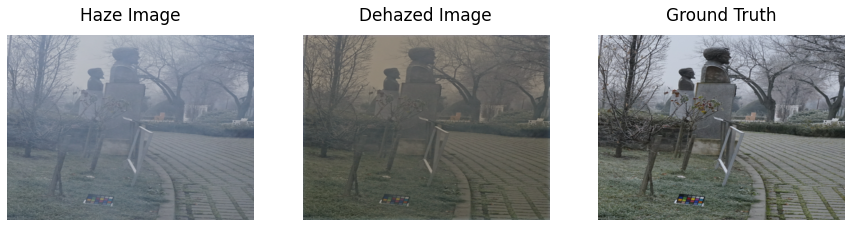

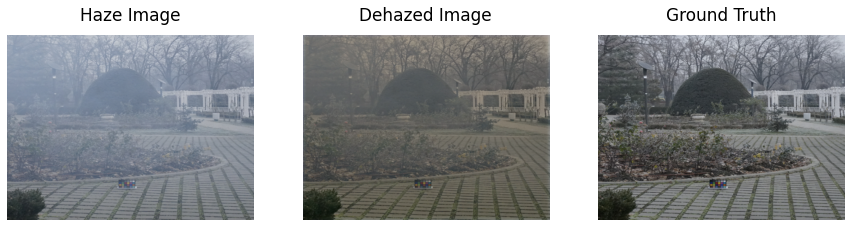

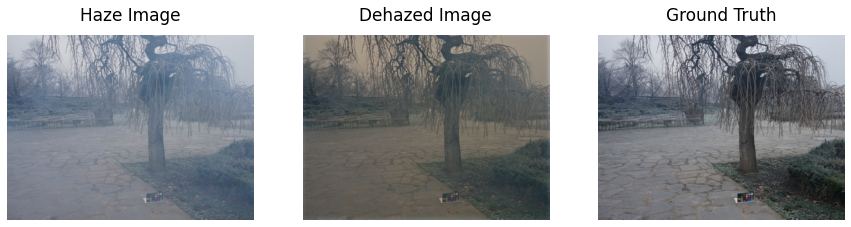

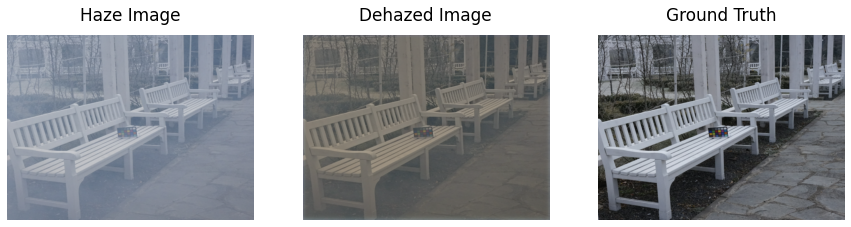

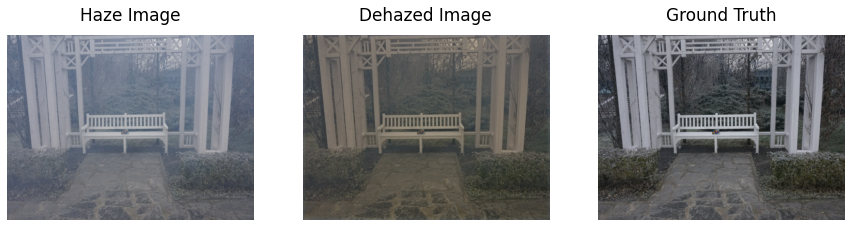

Averaga SSIM 0.7561565041542053
Averaga PSNR 18.48216694730349
Averaga time 0.740128469467163
Averaga MSE 0.014651241898536681


In [ ]:
test_net = tf.keras.models.load_model('/content/trained_model', compile = False)
evaluate(test_net, test_data)